# You can run this train model in kaggle through this link!
https://www.kaggle.com/code/selix075/classification-training-testing/edit

# 1. Load packages and set hyperparameters

In [1]:
import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dropout,Dense,Conv2D,BatchNormalization,MaxPooling2D,Flatten
from keras.optimizers import SGD
from keras import initializers
from keras import regularizers

import sys
# if '../input/train-model/' not in sys.path:
#     sys.path.append('../input/train-model/')
#sys.path
#del sys
#sys.path.remove('../input/train-model/')
import sys
if '../input/pre-code' not in sys.path:
    sys.path.append('../input/pre-code')
if '../input/pre-code-nodenoise' not in sys.path:
    sys.path.append('../input/pre-code-nodenoise')

print(sys.path)
#from my_utils import utils_paths
#del utils_paths
#from image_preprocessing import preprocess_image
#from image_preprocessing_noDenoise import preprocess_image

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle
import cv2
import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/root/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/root/src/BigQuery_Helper', '../input/pre-code', '../input/pre-code-nodenoise']


In [2]:
try:
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("-d","--dataset",#required=True,
                    default="../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database",
                    help="path to input dataset of images")
    ap.add_argument("-m","--model",#required=True,
                    default="/kaggle/working/",
                    help="path to output trained model ")
    ap.add_argument("-l","-label-bin",#required=True,
                    default=114,
                    help="path to output label binarizer")
    ap.add_argument("-p","--plot",#required=True,
                    default="/kaggle/working/",
                    help="path to output accuracy/loss plot")
    args = vars(ap.parse_args())
except:
    args={}
    
    #Set up the directories may be used
    Paths=['../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/', #0
           '../input/chest-xray-pneumoniacovid19tuberculosis/train/', #1
           '../input/chest-xray-pneumoniacovid19tuberculosis/test/', #2
           '../input/preprocessed/output/output', #3
           '../input/preprocessed/extra/extra', #4
           '../input/preprocessed/extra/extra', #5
           '../input/segmentation/Segmentation/Segmentation',#6
           '../input/segmentation/extra- segmentation/extra', #7
           '../input/segmentation/extra- segmentation/extra',#8
           '../input/old-data-split/training', #9
           '../input/old-data-split/validation', #10
           '../input/old-data-split/testing' #11
          ]
    
    args["training_dataset"] = Paths[0]
    args["finetune_dataset"] = Paths[1]
    args["test_dataset"] = Paths[2]
    
    args["target_classes"] = [["Normal","Tuberculosis"], #0
                              ["NORMAL","TURBERCULOSIS"], #1
                              ["NORMAL","TURBERCULOSIS"], #2
                              ["processed_normal","processed_tb"], #3
                              ["train_normal","train_tb"], #4
                              ["test_normal","test_tb"], #5
                              ["normal_segmentation","tb_segmentation"], #6
                              ["Seg_train_normal","Seg_train_tb"], #7
                              ["Seg_test_normal","Seg_test_tb"], #8
                              ["Normal","Tuberculosis"], #9
                              ["Normal","Tuberculosis"], #10
                              ["Normal","Tuberculosis"] #11
                             ]
    training_classes=args["target_classes"][0]
    finetune_classes=args["target_classes"][1]
    test_classes=args["target_classes"][2]
    #"../input/segmentation-self/Segmentation"
    merged_list=[(Paths[1],args["target_classes"][1]),
                 (Paths[9],args["target_classes"][9]),
                 (Paths[10],args["target_classes"][10])]
    
    #Initialize the hyperparameters
    args["INIT_LR"]=0.01 
    args["EPOCHS"]=200 
    args["MODEL_TYPE"]="densenet201" #（maybe:“CNN”，“MLP”，“densenet201”）
    args["BATCH_SIZE"]=300 
    args["NEW_WIDTH"]=224
    args["NEW_HEIGHT"]=224
    args["SEED"]=114514 #42
    args["SCALE"] = False
    args["PRE"]=False
print(args)



{'training_dataset': '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/', 'finetune_dataset': '../input/chest-xray-pneumoniacovid19tuberculosis/train/', 'test_dataset': '../input/chest-xray-pneumoniacovid19tuberculosis/test/', 'target_classes': [['Normal', 'Tuberculosis'], ['NORMAL', 'TURBERCULOSIS'], ['NORMAL', 'TURBERCULOSIS'], ['processed_normal', 'processed_tb'], ['train_normal', 'train_tb'], ['test_normal', 'test_tb'], ['normal_segmentation', 'tb_segmentation'], ['Seg_train_normal', 'Seg_train_tb'], ['Seg_test_normal', 'Seg_test_tb'], ['Normal', 'Tuberculosis'], ['Normal', 'Tuberculosis'], ['Normal', 'Tuberculosis']], 'INIT_LR': 0.01, 'EPOCHS': 200, 'MODEL_TYPE': 'densenet201', 'BATCH_SIZE': 300, 'NEW_WIDTH': 224, 'NEW_HEIGHT': 224, 'SEED': 114514, 'SCALE': False, 'PRE': False}


usage: ipykernel_launcher.py [-h] [-d DATASET] [-m MODEL] [-l L] [-p PLOT]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-7050f863-153d-46cc-897b-1e742f3f4f9d.json


In [3]:
random.seed(args["SEED"]) 

# 2. define important functions for training and testing

In [4]:
def input_images_preprocess(data_dir,target_classes,scaling=False,select_width=None,preprocess=True): #[256*2+1,256*3+1]
    from sklearn.preprocessing import LabelBinarizer
    from keras.utils import to_categorical
    import cv2
    import os
    from tqdm import tqdm
    from tqdm.notebook import tqdm_notebook
    import numpy as np
    
    print(f"[INFO] starting reading in {data_dir}")
    ## Load and preprocess the test data
    data = []
    labels = []
    image_w=[]
    image_h=[]
    # Iterate over test data
    for class_name in target_classes:
        class_path = os.path.join(data_dir, class_name)
        
        print(f'[INFO] read the {class_name} images')
        
        for imagePath in tqdm_notebook(os.listdir(class_path),dynamic_ncols=True):
            
            image_path = os.path.join(class_path, imagePath)
            image = cv2.imread(image_path)
            
            image_h.append(image.shape[0])
            image_w.append(image.shape[1])
            
            if select_width:
                image=image[:,select_width[0]:select_width[1]]
                #print("select the width from",select_width[0],"to",select_width[1])
            if preprocess:
                image=preprocess_image(image_path, size=(224, 224))
            image = cv2.resize(image, (args["NEW_WIDTH"], args["NEW_HEIGHT"]))
            data.append(image)
            labels.append(class_name)
        print(f'[INFO] {class_name} images reading done')

    print(f"[INFO] {data_dir} both classes reading done")

    if args["MODEL_TYPE"]=="MLP":
        # If you use MLP, you flatten the two-dimensional image into a one-dimensional vector
        data=[image.flatten() for image in data]
        print("Indeed, with the MLP model, the two-dimensional image is flattened into a one-dimensional vector")
    else:
        print("not a MLP model")

    # Convert labels to binary labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    #labels = to_categorical(labels, len(lb.classes_)) 
    labels=np.array(labels)
    data = np.array(data, dtype="float16")
    if scaling:
        data=data / 255.0
    
    print("data.shape:",data.shape)
    print("labels.shape:",labels.shape)
    
    return data,labels

In [5]:
def read_merge_data(merged_list, n_w, n_h):  
    merged_data = np.zeros((1, n_w*n_h*3))
    merged_labels = np.zeros((1, 1))
    for data_dir, target_classes in merged_list:  
        data, labels = input_images_preprocess(data_dir, target_classes, 
                                               preprocess=args["PRE"],scaling=args["SCALE"])  
        merged_data = np.concatenate((merged_data, data), axis=0) 
        merged_labels = np.concatenate((merged_labels, labels),axis=0)
    merged_data=merged_data[1:,]
    merged_labels=merged_labels[1:,]
    print("[INFO] Merge Done!")  
    print("merged_data.shape:", merged_data.shape)  
    print("merged_labels.shape:", merged_labels.shape)  
    return merged_data, merged_labels

In [6]:

def create_model(model_type):
    import tensorflow as tf
    model = tf.keras.models.Sequential()
    # kernel regularizer=regularizers,12(0.01)
    # keras.initializers.TruncatedNormal(mean=0.0，stddey=0.05， seed=None)
    # #initializers.random normal
    # model.add(Dronout(0.8))
    
    if model_type=="MLP":
        from keras.layers import Dropout,Dense,Conv2D,BatchNormalization,MaxPooling2D,Flatten
        model.add(Dense(512,input_shape=(args["NEW_WIDTH"]*args["NEW_HEIGHT"]*3,),
                        activation="relu")) 
        #model.add(Dropout(0.1,trainable=True))
        model.add(Dense(256,activation="relu",))
        #model.add(Dropout(0.1,trainable=True))
        model.add(Dense(1,activation="sigmoid"))

    elif model_type=="CNN": # Build a more complex CNN model with Batch Normalization and Dropout

        model.add(Conv2D(32, (3, 3), activation='relu', 
                         input_shape=(args["NEW_WIDTH"], args["NEW_HEIGHT"], 3)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    
    elif model_type=="densenet201":
        # Pretrained backbone
        #model = keras_cv.models.DenseNetBackbone.from_preset("densenet201_imagenet")
        from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
        from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
        from tensorflow.keras.models import Model

        # load the pretrianed DenseNet201 model
        base_model = DenseNet201(weights='/kaggle/input/densenetbackbone/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                            include_top=False, input_shape=(args["NEW_WIDTH"], args["NEW_HEIGHT"], 3))

        #freeze the backbone layer
        for layer in base_model.layers:
            layer.trainable = False

        # add the classifier to DenseNet
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)  
        predictions = Dense(1, activation='sigmoid')(x)  

        # construct the whole model
        model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
def flatten_dict(input):
    result={}
    for k, v in input.items():
        if not isinstance(v, dict):  
            result[k] = v
        else:
            for v_k,v_v in v.items():
                result[f"{k}_{v_k}"] = v_v
    return result

In [8]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import preprocessing
def plot_confusion_matrix(classes_list, conf_mat, training_output_dir,present=""):
#     display_labels_x = []
#     display_labels_y = []
#     for label in classes_list:
#         display_labels_x += ["{0}\nn={1:.0f}".format(label, sum(conf_mat[:,i]))]
#         display_labels_y += ["{0}\nn={1:.0f}".format(label, sum(conf_mat[i,:]))]
#         print(display_labels_x,display_labels_y)
        #display_labels_x=[1,0]
        #yticks=display_labels_y=[1,0]
    display = ConfusionMatrixDisplay(confusion_matrix=preprocessing.normalize(conf_mat, norm="l1"), 
                                     #xticks=display_labels_x, 
                                     #yticks=display_labels_y
                                     display_labels=classes_list
                                    )
    display.plot(cmap="Blues",values_format=".2g")
    plt.title(present)
    plt.show()
    plt.savefig(f"{present}confusion_matrix.png")

# 计算ROC曲线所需的值  
def ROC_plot(Y_valid, Y_pred,present=""):
    from sklearn.metrics import roc_curve,roc_auc_score
    
    fpr, tpr, thresholds = roc_curve(Y_valid, Y_pred)  

    # Calculate the AUC value 
    auc = roc_auc_score(Y_valid, Y_pred)  
    print('AUC: %.3f' % auc)  

    # draw the ROC plot  
    plt.figure()  
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.plot(fpr, tpr, color='red',label='AUC = {:.3f})'.format(auc))  
    plt.xlabel('False positive rate')    
    plt.ylabel('True positive rate')  
    plt.title('ROC Curve')    
    plt.legend(loc='best')   
    plt.show()
    plt.savefig(f"{present}ROC_plot.png")

def predict_model(model,test_data,binary_labels,present=""):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report 
    
    # Make predictions
    predictions = model.predict(test_data)
    
    #only select first column，Convert all forms of output to one dimension
    binary_labels=binary_labels.flatten()
    
    #convert prediction to 1 or 0
    binary_predictions = np.where(predictions.T > 0.5, 1, 0).flatten()
    
    print(binary_predictions,binary_predictions.shape)
    print(binary_labels,binary_labels.shape)

    # Evaluate the predictions
    report=classification_report(binary_labels,binary_predictions,digits=4)
    print(report)
    dic_report=classification_report(binary_labels,binary_predictions,digits=4,output_dict=True)
    dic_report = flatten_dict(dic_report)  


    # plot confusion matrix
    conf_mat = confusion_matrix(binary_labels, binary_predictions)
    classes_list = ["Normal", "Tuberculosis"]
    plot_confusion_matrix(classes_list, conf_mat, training_output_dir="/.", present=present)
    
    # plot ROC plot
    ROC_plot(binary_labels, predictions, present)
    
    # Find a normal sample with incorrect predictions
    normal_wrong_indices=np.where(binary_predictions[binary_labels==0]!=binary_labels[binary_labels==0])
    tuberculosis_wrong_indices=np.where(binary_predictions[binary_labels==1]!=binary_labels[binary_labels==1])
    print("normal_wrong_indices:",normal_wrong_indices[0].tolist())
    print("tuberculosis_wrong_indices:",tuberculosis_wrong_indices[0].tolist())
    
    return dic_report

In [9]:
# from sklearn.metrics import classification_report  
# y_true = [0, 1, 1, 0]  
# y_pred = [0, 0, 1, 1]  
# print(classification_report(y_true, y_pred))

In [10]:
def train_model(model,trainX,testX,trainY,testY,patience, present="", model_type=""):
    import tensorflow as tf
    
    print(f"[INFO] {present} strating training！（happy）")
    
    #create a callback
    from tensorflow.keras.callbacks import Callback,EarlyStopping
    early_stop = EarlyStopping(patience=patience, restore_best_weights=True)
    

    from tensorflow.keras.optimizers import Adam
    opt = Adam(lr=args["INIT_LR"]) 
    
    loss_fuction="binary_crossentropy"
#     if model_type!="MLP":
#         loss_fuction="binary_crossentropy"
#     else: #redefine the loss function to use CBP
#         def CBP_loss(y_true, y_pred):
#             grad_loss = tf.reduce_mean(tf.square(y_true - y_pred))
            
#             return loss
#         loss_fuction=

    #compile the model
    model.compile(loss=loss_fuction,
                  optimizer=opt,
                  metrics=["accuracy"])

    #Stores the accuracy and loss of each epoch    
    training_accuracy = []    
    validation_accuracy = []    
    training_loss = []    
    validation_loss = []    

    # A custom callback function to record accuracy and loss for each epoch   
    class CustomCallback(tf.keras.callbacks.Callback):    
        def on_epoch_end(self, epoch, logs=None):    
            training_accuracy.append(logs['accuracy'])    
            validation_accuracy.append(logs['val_accuracy'])    
            training_loss.append(logs['loss'])    
            validation_loss.append(logs['val_loss'])     
    
    # Create an instance of a custom callback function  
    custom_callback = CustomCallback()    

    # Define a list of callback functions  
    callbacks = [custom_callback, early_stop]   
    
    import time  
    # Start recording the time before training starts  
    start_time = time.time() 

    # Training network model
    H = model.fit(trainX,trainY,validation_data=(testX, testY),callbacks=callbacks,
                  epochs=args["EPOCHS"],batch_size=args["BATCH_SIZE"])

    # End the record and calculate the total time 
    end_time = time.time()  
    total_time = end_time - start_time
    hours, remainder = divmod(total_time, 3600)    
    minutes, seconds = divmod(remainder, 60)  
    print(f"{present} Total training time: {hours} hours {minutes} minutes {seconds} seconds")
    
    
    # Plot accuracy and loss over time  
    plt.figure(figsize=(10, 6))      
    plt.plot(range(len(training_loss)), training_loss, label="Training Loss")    
    plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss")    
    plt.xlabel(f"{present} Epoch")    
    plt.ylabel(f"{present} Loss")    
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))    
    plt.plot(range(len(training_accuracy)), training_accuracy, label="Training Accuracy")    
    plt.plot(range(len(validation_accuracy)), validation_accuracy, label="Validation Accuracy")  
    plt.xlabel(f"{present} Epoch")    
    plt.ylabel(f"{present} Accuracy")    
    plt.legend()
    plt.show()
    print(f"[INFO] {present} training complete！（happy）")

In [11]:
def cross_validation(data, labels, patience,nfolds=5,random_state=114514, model_type=""):
    from sklearn.model_selection import KFold,StratifiedKFold
    from keras.models import load_model
    import pandas as pd
    import matplotlib.pyplot as plt
    # Define the K-fold Cross Validator
    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    # K-fold Cross Validation model evaluation
    fold=0
    
    #establish the reports for the Kfold models
    reports = {}
    
    for train, test in kfold.split(data, labels):    
        import tensorflow as tf 
        strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"]) 
        # Using dual Gpus or single Gpus, "/gpu:1"
        with strategy.scope(): 
            model = create_model(args["MODEL_TYPE"])
            train_model(model,data[train],data[test],labels[train],labels[test],
                        patience=patience,present=f"{fold} fold training",model_type=model_type)
            #save the model
            print(f"[INFO]{fold} fold {model_type} model storing...")
            model.save(f'{fold}_fold_{model_type}_chest_xray_model.h5')
            print(f"[INFO]{fold} fold {model_type} model storing complete！")
            
            model=load_model(f'{fold}_fold_{model_type}_chest_xray_model.h5')
            
            #fill in the reports for the Kfold models
            report = predict_model(model,data[test],labels[test],f"{fold} fold validation")
            reports[f"{fold}_fold"]=report
        fold=fold+1
    reports=pd.DataFrame.from_dict(reports)
    reports.to_csv('cross_validation_reports.csv', index=True)
    print(reports)

# 3. Load the data for training

In [12]:
try:
    pre_MLP_judge=MLP_judge
except:
    pre_MLP_judge="nothing"

if args["MODEL_TYPE"]=="MLP":
    MLP_judge=True
else:
    MLP_judge=False

try:
    data, labels=data, labels
    if pre_MLP_judge!=MLP_judge:
        raise("reload the data since the MLP requires different data inputs from other models")
except:
    data, labels= input_images_preprocess(data_dir=Paths[0],
                                          target_classes = args["target_classes"][0],
                                          preprocess=args["PRE"],scaling=args["SCALE"])

# data, labels = merged_data, merged_labels

[INFO] starting reading in ../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/
[INFO] read the Normal images


  0%|          | 0/3500 [00:00<?, ?it/s]

[INFO] Normal images reading done
[INFO] read the Tuberculosis images


  0%|          | 0/700 [00:00<?, ?it/s]

[INFO] Tuberculosis images reading done
[INFO] ../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/ both classes reading done
not a MLP model
data.shape: (4200, 224, 224, 3)
labels.shape: (4200, 1)


In [13]:
print(data.shape,labels.shape)

(4200, 224, 224, 3) (4200, 1)


# 4. Training (5-fold cross validation)
# > If you want to save more time, you can intercept codes here once you obtain the 0-fold model.

[INFO] 0 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 55s 2s/step - loss: 1.0283 - accuracy: 0.7777 - val_loss: 0.8004 - val_accuracy: 0.8655
Epoch 2/200
12/12 [==============================] - 10s 819ms/step - loss: 0.3829 - accuracy: 0.8774 - val_loss: 0.2801 - val_accuracy: 0.9131
Epoch 3/200
12/12 [==============================] - 10s 820ms/step - loss: 0.1757 - accuracy: 0.9324 - val_loss: 0.1771 - val_accuracy: 0.9310
Epoch 4/200
12/12 [==============================] - 10s 815ms/step - loss: 0.1237 - accuracy: 0.9542 - val_loss: 0.0953 - val_accuracy: 0.9619
Epoch 5/200
12/12 [==============================] - 10s 819ms/step - loss: 0.0888 - accuracy: 0.9711 - val_loss: 0.0724 - val_accuracy: 0.9762
Epoch 6/200
12/12 [==============================] - 10s 822ms/step - loss: 0.0709 - accuracy: 0.9795 - val_loss: 0.0664 - val_accuracy: 0.9833
Epoch 7/200
12/12 [==============================] - 10s 817ms/step - loss: 0.0636 - accur

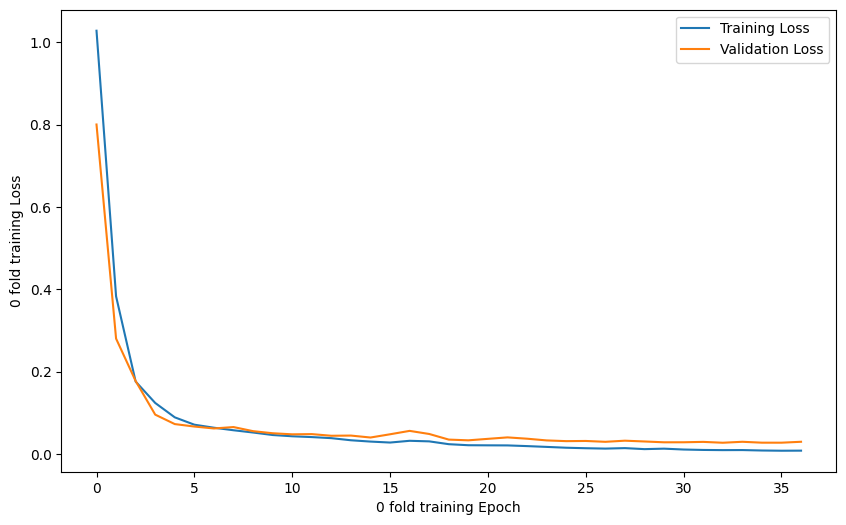

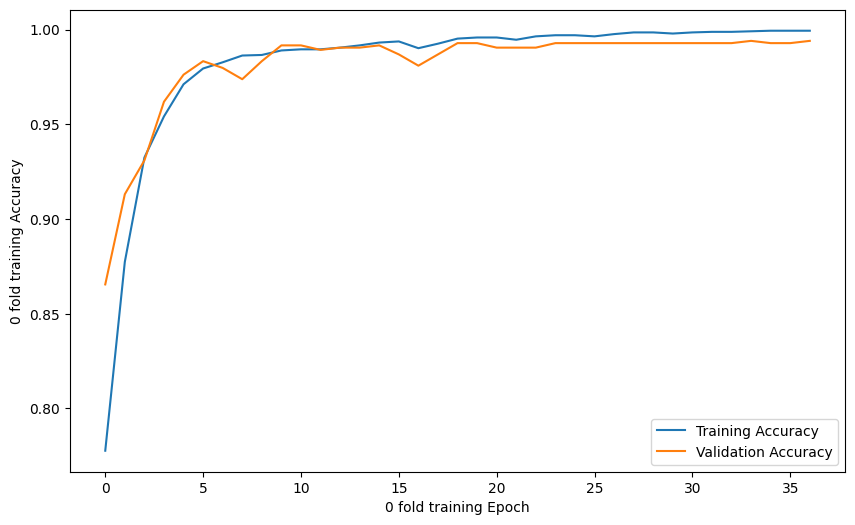

[INFO] 0 fold training training complete！（happy）
[INFO]0 fold densenet201 model storing...


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]0 fold densenet201 model storing complete！
27/27 [==============================] - 11s 152ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

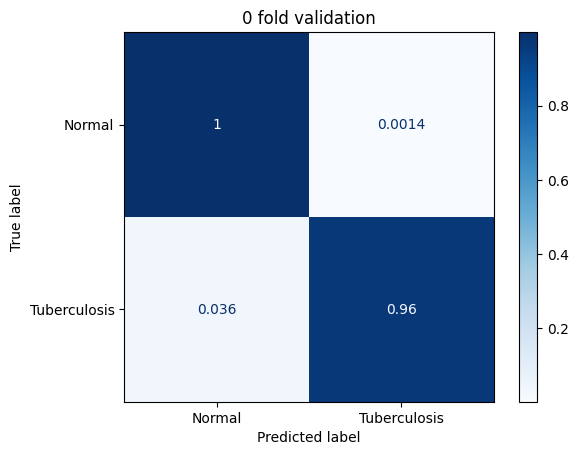

AUC: 0.998


<Figure size 640x480 with 0 Axes>

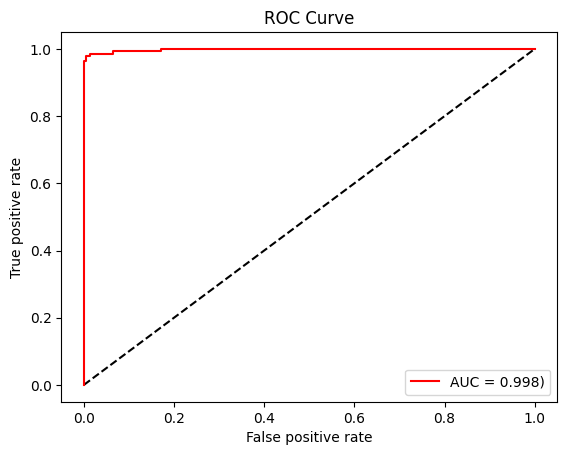

normal_wrong_indices: [115]
tuberculosis_wrong_indices: [53, 66, 103, 121, 136]
[INFO] 1 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 29s 1s/step - loss: 1.3947 - accuracy: 0.7274 - val_loss: 0.4986 - val_accuracy: 0.8714
Epoch 2/200
12/12 [==============================] - 10s 819ms/step - loss: 0.3920 - accuracy: 0.8824 - val_loss: 0.1829 - val_accuracy: 0.9298
Epoch 3/200
12/12 [==============================] - 9s 751ms/step - loss: 0.1804 - accuracy: 0.9271 - val_loss: 0.1832 - val_accuracy: 0.9345
Epoch 4/200
12/12 [==============================] - 10s 819ms/step - loss: 0.1295 - accuracy: 0.9521 - val_loss: 0.1356 - val_accuracy: 0.9536
Epoch 5/200
12/12 [==============================] - 10s 819ms/step - loss: 0.0998 - accuracy: 0.9658 - val_loss: 0.1114 - val_accuracy: 0.9619
Epoch 6/200
12/12 [==============================] - 10s 822ms/step - loss: 0.0804 - accuracy: 0.9729 - val_loss: 0.1024 - val_accuracy: 0.9643
Epoch 7/200

<Figure size 640x480 with 0 Axes>

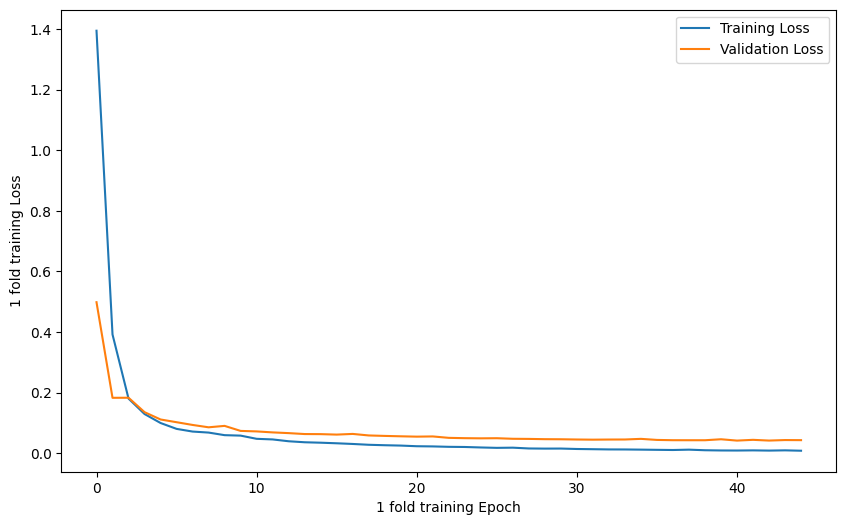

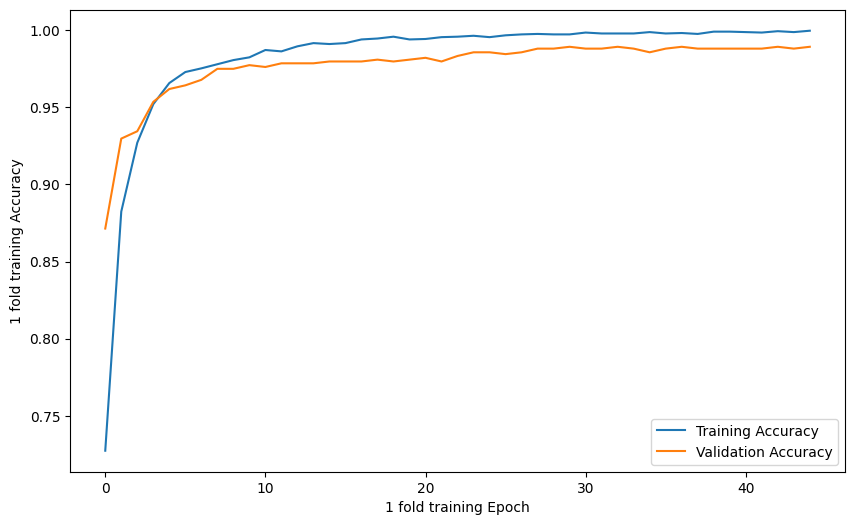

[INFO] 1 fold training training complete！（happy）
[INFO]1 fold densenet201 model storing...


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]1 fold densenet201 model storing complete！
27/27 [==============================] - 6s 79ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

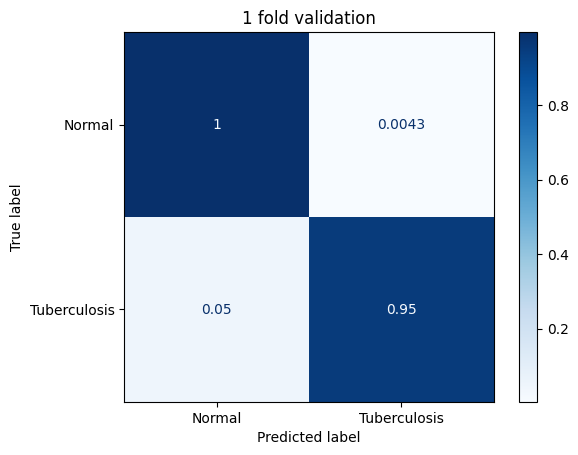

AUC: 0.996


<Figure size 640x480 with 0 Axes>

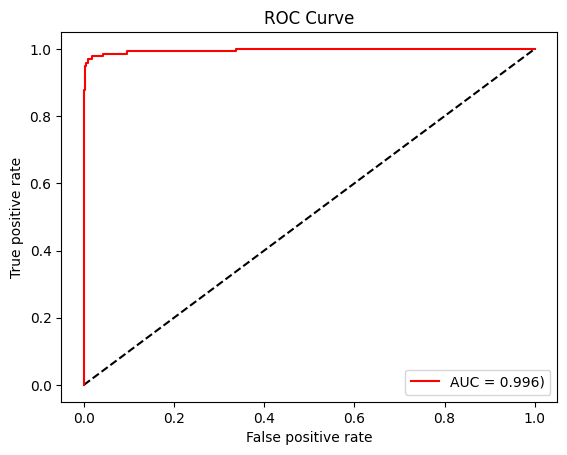

normal_wrong_indices: [159, 247, 566]
tuberculosis_wrong_indices: [0, 13, 31, 42, 79, 83, 116]
[INFO] 2 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 29s 1s/step - loss: 0.9746 - accuracy: 0.7917 - val_loss: 0.2668 - val_accuracy: 0.9036
Epoch 2/200
12/12 [==============================] - 10s 824ms/step - loss: 0.2862 - accuracy: 0.8994 - val_loss: 0.1317 - val_accuracy: 0.9452
Epoch 3/200
12/12 [==============================] - 10s 823ms/step - loss: 0.1446 - accuracy: 0.9446 - val_loss: 0.1125 - val_accuracy: 0.9655
Epoch 4/200
12/12 [==============================] - 10s 821ms/step - loss: 0.1107 - accuracy: 0.9613 - val_loss: 0.1070 - val_accuracy: 0.9607
Epoch 5/200
12/12 [==============================] - 10s 822ms/step - loss: 0.0998 - accuracy: 0.9661 - val_loss: 0.0846 - val_accuracy: 0.9726
Epoch 6/200
12/12 [==============================] - 10s 823ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.0657 - val_accuracy: 0.

<Figure size 640x480 with 0 Axes>

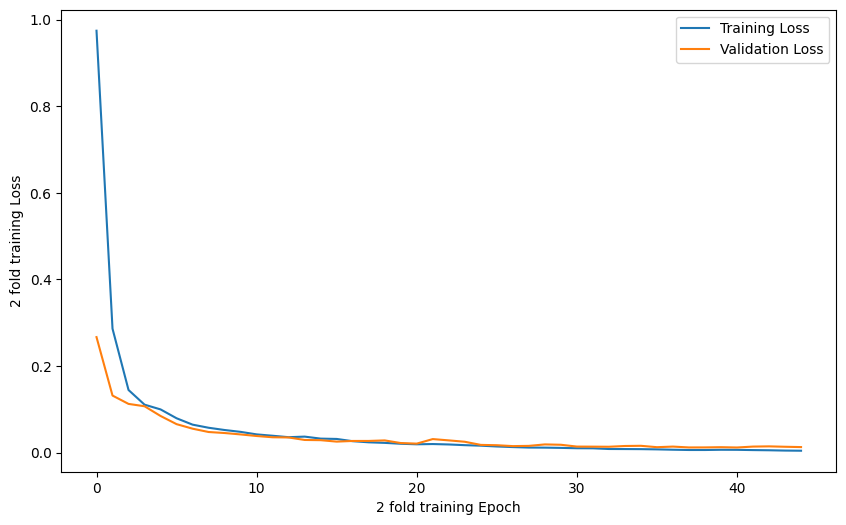

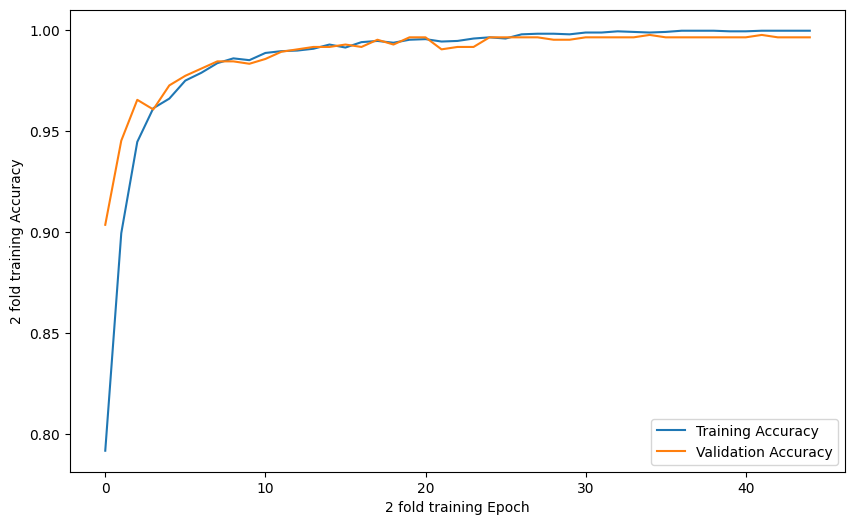

[INFO] 2 fold training training complete！（happy）
[INFO]2 fold densenet201 model storing...


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]2 fold densenet201 model storing complete！
27/27 [==============================] - 6s 79ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

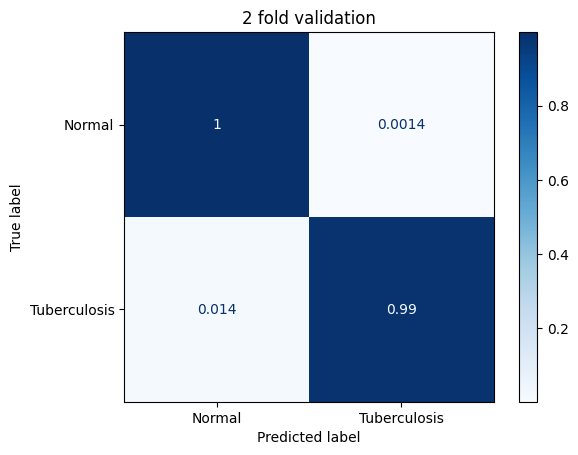

AUC: 1.000


<Figure size 640x480 with 0 Axes>

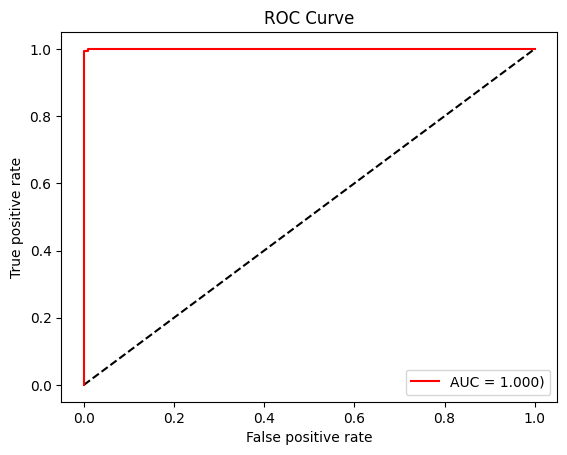

normal_wrong_indices: [487]
tuberculosis_wrong_indices: [59, 88]
[INFO] 3 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 29s 1s/step - loss: 0.7417 - accuracy: 0.8062 - val_loss: 0.4877 - val_accuracy: 0.8190
Epoch 2/200
12/12 [==============================] - 10s 814ms/step - loss: 0.2274 - accuracy: 0.9164 - val_loss: 0.1495 - val_accuracy: 0.9429
Epoch 3/200
12/12 [==============================] - 10s 821ms/step - loss: 0.1120 - accuracy: 0.9583 - val_loss: 0.0983 - val_accuracy: 0.9726
Epoch 4/200
12/12 [==============================] - 10s 825ms/step - loss: 0.0919 - accuracy: 0.9670 - val_loss: 0.0913 - val_accuracy: 0.9690
Epoch 5/200
12/12 [==============================] - 10s 819ms/step - loss: 0.0682 - accuracy: 0.9765 - val_loss: 0.0726 - val_accuracy: 0.9798
Epoch 6/200
12/12 [==============================] - 10s 816ms/step - loss: 0.0556 - accuracy: 0.9842 - val_loss: 0.0647 - val_accuracy: 0.9833
Epoch 7/200
12/12 [======

<Figure size 640x480 with 0 Axes>

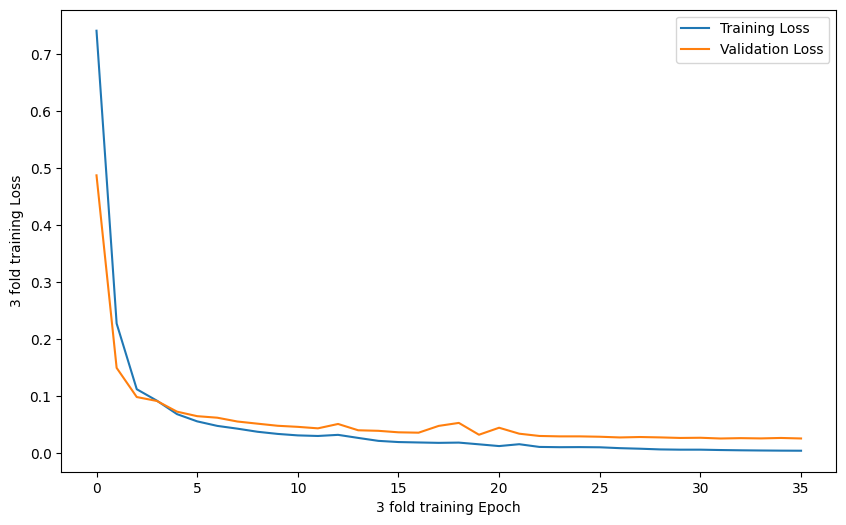

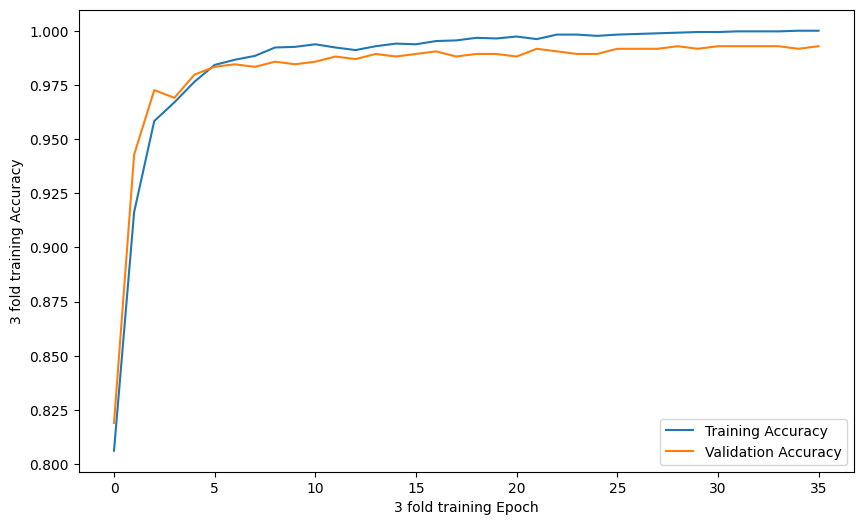

[INFO] 3 fold training training complete！（happy）
[INFO]3 fold densenet201 model storing...


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]3 fold densenet201 model storing complete！
27/27 [==============================] - 6s 77ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

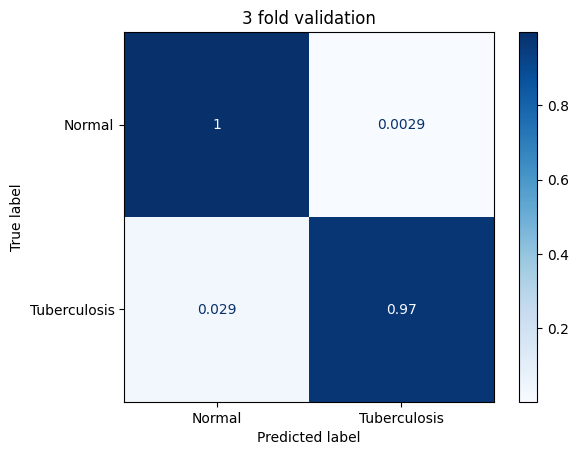

AUC: 0.995


<Figure size 640x480 with 0 Axes>

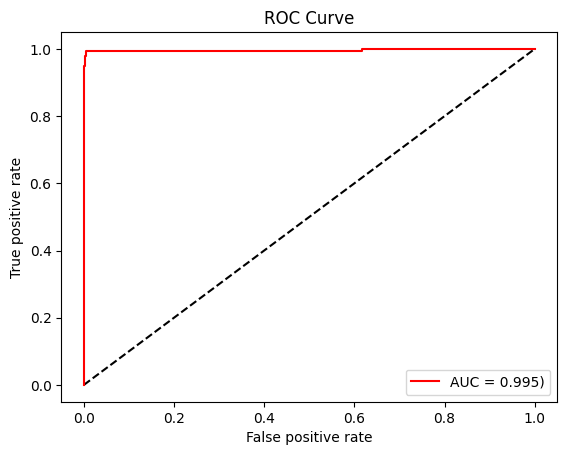

normal_wrong_indices: [311, 495]
tuberculosis_wrong_indices: [5, 68, 84, 112]
[INFO] 4 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 30s 1s/step - loss: 1.4020 - accuracy: 0.7202 - val_loss: 0.6221 - val_accuracy: 0.8679
Epoch 2/200
12/12 [==============================] - 10s 819ms/step - loss: 0.3457 - accuracy: 0.9030 - val_loss: 0.2356 - val_accuracy: 0.8929
Epoch 3/200
12/12 [==============================] - 10s 820ms/step - loss: 0.1968 - accuracy: 0.9289 - val_loss: 0.1424 - val_accuracy: 0.9345
Epoch 4/200
12/12 [==============================] - 10s 819ms/step - loss: 0.1244 - accuracy: 0.9524 - val_loss: 0.1090 - val_accuracy: 0.9607
Epoch 5/200
12/12 [==============================] - 10s 824ms/step - loss: 0.0909 - accuracy: 0.9717 - val_loss: 0.0914 - val_accuracy: 0.9702
Epoch 6/200
12/12 [==============================] - 9s 754ms/step - loss: 0.0776 - accuracy: 0.9768 - val_loss: 0.0918 - val_accuracy: 0.9726
Epoch 7/200
1

<Figure size 640x480 with 0 Axes>

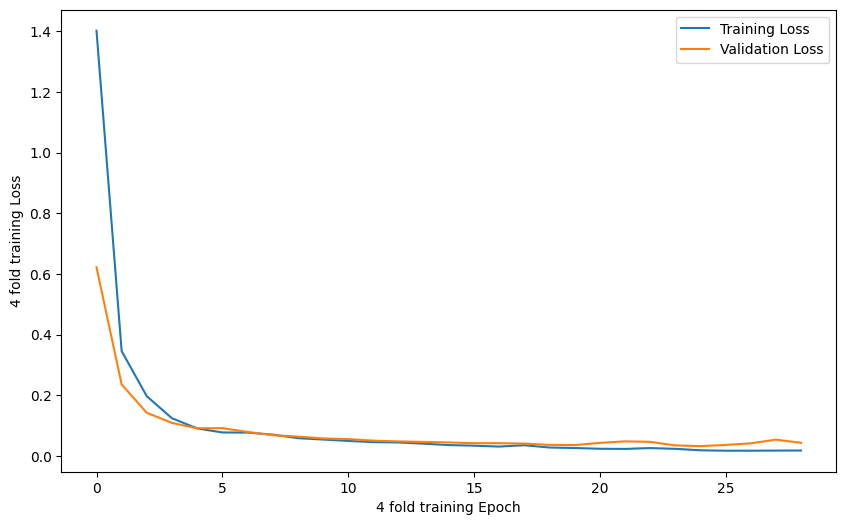

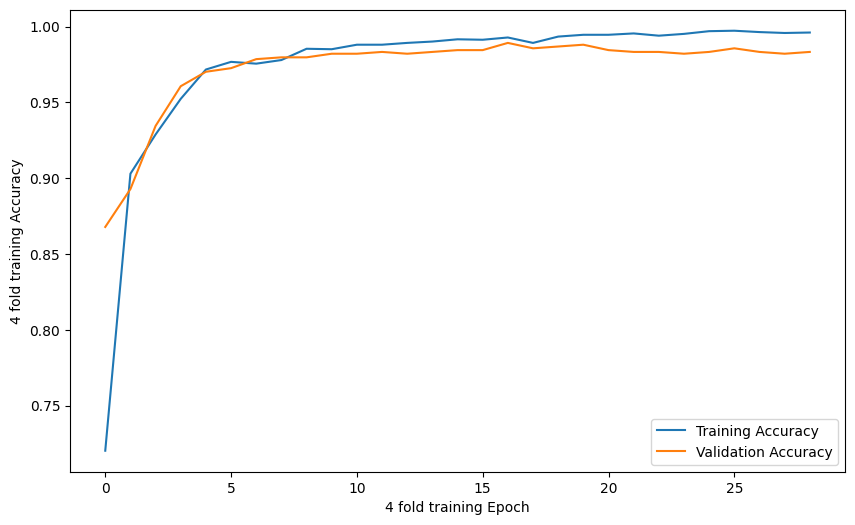

[INFO] 4 fold training training complete！（happy）
[INFO]4 fold densenet201 model storing...


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]4 fold densenet201 model storing complete！
27/27 [==============================] - 7s 78ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

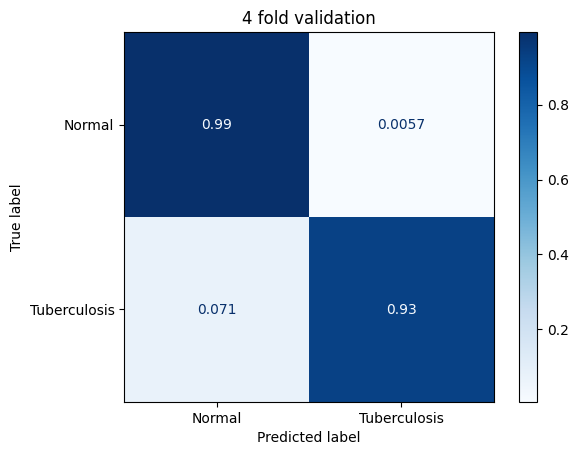

AUC: 0.999


<Figure size 640x480 with 0 Axes>

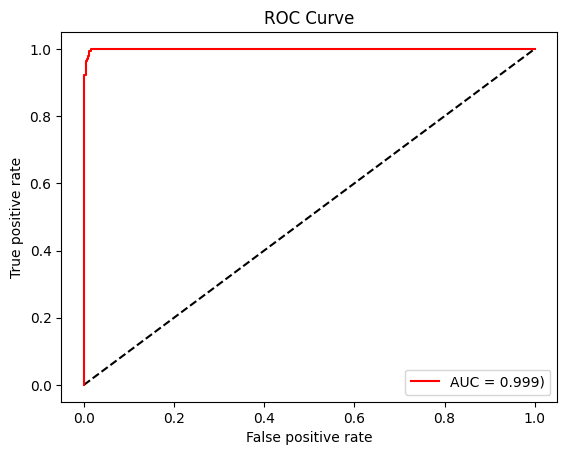

normal_wrong_indices: [76, 341, 402, 556]
tuberculosis_wrong_indices: [51, 57, 62, 71, 78, 85, 106, 107, 114, 120]
                            0_fold      1_fold      2_fold      3_fold  \
0_precision               0.992898    0.990057    0.997147    0.994302   
0_recall                  0.998571    0.995714    0.998571    0.997143   
0_f1-score                0.995726    0.992877    0.997859    0.995720   
0_support               700.000000  700.000000  700.000000  700.000000   
1_precision               0.992647    0.977941    0.992806    0.985507   
1_recall                  0.964286    0.950000    0.985714    0.971429   
1_f1-score                0.978261    0.963768    0.989247    0.978417   
1_support               140.000000  140.000000  140.000000  140.000000   
accuracy                  0.992857    0.988095    0.996429    0.992857   
macro avg_precision       0.992772    0.983999    0.994976    0.989905   
macro avg_recall          0.981429    0.972857    0.992143    0.984286 

<Figure size 640x480 with 0 Axes>

In [14]:
from tensorflow import test
if test.is_gpu_available():
    cross_validation(data, labels, nfolds=5, patience=4,random_state = args["SEED"],model_type=args["MODEL_TYPE"])
else:
    print("no GPU, you'd better not run it")

# 5. Download the saved models from training

In [15]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink,FileLinks
for i in os.listdir("/kaggle/working"):
    print(i)
    try:
        FileLink(i)
    except:
        FileLinks(i)

/kaggle/working
['4_fold_densenet201_chest_xray_model.h5', '2 fold validationROC_plot.png', '1 fold validationconfusion_matrix.png', '3_fold_densenet201_chest_xray_model.h5', '3 fold validationconfusion_matrix.png', '0 fold validationconfusion_matrix.png', '0_fold_densenet201_chest_xray_model.h5', '4 fold validationROC_plot.png', '0 fold validationROC_plot.png', '4 fold validationconfusion_matrix.png', '3 fold validationROC_plot.png', '2_fold_densenet201_chest_xray_model.h5', '1 fold validationROC_plot.png', '.virtual_documents', '2 fold validationconfusion_matrix.png', 'cross_validation_reports.csv', '1_fold_densenet201_chest_xray_model.h5']
4_fold_densenet201_chest_xray_model.h5
2 fold validationROC_plot.png
1 fold validationconfusion_matrix.png
3_fold_densenet201_chest_xray_model.h5
3 fold validationconfusion_matrix.png
0 fold validationconfusion_matrix.png
0_fold_densenet201_chest_xray_model.h5
4 fold validationROC_plot.png
0 fold validationROC_plot.png
4 fold validationconfusion_m

In [16]:
FileLink(f'0_fold_{args["MODEL_TYPE"]}_chest_xray_model.h5')

/kaggle/working/0_fold_densenet201_chest_xray_model.h5

In [17]:
FileLink(f'1_fold_{args["MODEL_TYPE"]}_chest_xray_model.h5')

/kaggle/working/1_fold_densenet201_chest_xray_model.h5

In [18]:
FileLink(f'2_fold_{args["MODEL_TYPE"]}_chest_xray_model.h5')

/kaggle/working/2_fold_densenet201_chest_xray_model.h5

In [19]:
FileLink(f'3_fold_{args["MODEL_TYPE"]}_chest_xray_model.h5')

/kaggle/working/3_fold_densenet201_chest_xray_model.h5

In [20]:
FileLink(f'4_fold_{args["MODEL_TYPE"]}_chest_xray_model.h5')

/kaggle/working/4_fold_densenet201_chest_xray_model.h5

In [21]:
FileLink(f'cross_validation_reports.csv')

/kaggle/working/cross_validation_reports.csv

# 6. input the external testing dataset

In [22]:
test_data,binary_labels = input_images_preprocess(Paths[2],args["target_classes"][2],
                                               preprocess=args["PRE"],scaling=args["SCALE"]
                                               )

[INFO] starting reading in ../input/chest-xray-pneumoniacovid19tuberculosis/test/
[INFO] read the NORMAL images


  0%|          | 0/234 [00:00<?, ?it/s]

[INFO] NORMAL images reading done
[INFO] read the TURBERCULOSIS images


  0%|          | 0/41 [00:00<?, ?it/s]

[INFO] TURBERCULOSIS images reading done
[INFO] ../input/chest-xray-pneumoniacovid19tuberculosis/test/ both classes reading done
not a MLP model
data.shape: (275, 224, 224, 3)
labels.shape: (275, 1)


# 7. Reload the model and test the external dataset (Remember to change the paths!)


In [23]:
from keras.models import load_model
#model=load_model(f'3_fold_{args["MODEL_TYPE"]}_chest_xray_model.h5')
model=load_model(f'/kaggle/input/densenet201-finetuning/4_fold_densenet201_chest_xray_model.keras')
# you can change the directory!

9/9 [==============================] - 7s 363ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (275,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0

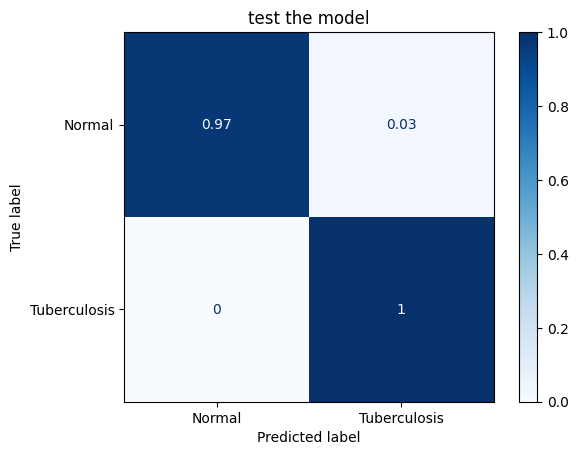

AUC: 0.999


<Figure size 640x480 with 0 Axes>

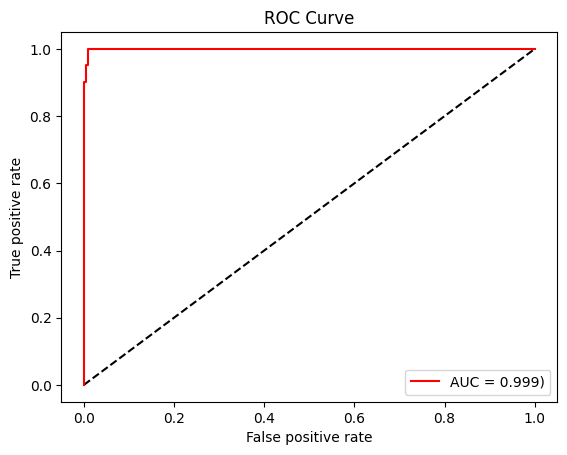

normal_wrong_indices: [118, 163, 175, 196, 199, 217, 222]
tuberculosis_wrong_indices: []
   0_precision  0_recall  0_f1-score  0_support  1_precision  1_recall  \
0          1.0  0.970085    0.984816        234     0.854167       1.0   

   1_f1-score  1_support  accuracy  macro avg_precision  macro avg_recall  \
0    0.921348         41  0.974545             0.927083          0.985043   

   macro avg_f1-score  macro avg_support  weighted avg_precision  \
0            0.953082                275                0.978258   

   weighted avg_recall  weighted avg_f1-score  weighted avg_support  
0             0.974545               0.975353                   275  


<Figure size 640x480 with 0 Axes>

In [24]:
other_dataset_report=predict_model(model,test_data,binary_labels,present="test the model")
import pandas as pd
other_dataset_report={k:[v] for k,v in other_dataset_report.items()}
other_dataset_report=pd.DataFrame(other_dataset_report)
print(other_dataset_report)
other_dataset_report.to_csv('other_dataset_report.csv', index=False)

In [25]:
import os
out_path=os.listdir("../input/chest-xray-pneumoniacovid19tuberculosis/test/NORMAL")
print(out_path[118])
print(out_path[196])
print(out_path[199])

NORMAL2-IM-0272-0001.jpeg
IM-0065-0001.jpeg
NORMAL2-IM-0373-0001.jpeg


# 8. Preparation for GUI

In [26]:
# test one image(preparation for GUI)
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import keras
print(keras.__version__)


# model = tf.keras.applications.DenseNet121(weights='imagenet') 
# print(model.summary())
model_type="preprocessed_densenet201" # This will change according to your own situation
def input_trained_model(model_type):
    from keras.models import load_model
    path={"raw_densenet201":"You changed it according to the way you put your model, and this path down here is also modified according to the way you put your model",
          "preprocessed_densenet201":"/kaggle/working/0_fold_densenet201_chest_xray_model.h5"
         }
    model_path = path[model_type]
    # This is to choose different paths according to different models (remember to change!) 
    # For example, model_path
    model = load_model(model_path)
    return model
model = input_trained_model(model_type)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.13.1


In [27]:
image_path = "../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-5.png" 
# This is the path you choose to enter the picture, then you will change the corresponding variable

def input_and_judge(model_type,model,image_path,scaling= False,preprocess=args["PRE"]):
    import cv2
    import numpy as np
    if preprocess:
        image=preprocess_image(image_path, size=(224, 224))
    else:
        image = cv2.imread(image_path)
        #print(image.shape)
        image = cv2.resize(image, (224, 224))
    
    if scaling:
        image = np.array(image) / 255.0 #scaling
    image = np.array([image])
    #because there're only one image, we need to add one dimension to fit the model's shape
    #print(image.shape)
    if model_type == "MLP":
        image=image.flatten()
    #print(image)
    out = model.predict(image)
    out ="turberculosis" if out>0.5 else "normal"
    return out

result = input_and_judge(model_type,model,image_path,scaling=args["SCALE"])

print(f'{image_path}: {result}')

1/1 [==============================] - 5s 5s/step
../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-5.png: normal
